In [1]:
!pip3 install statsmodels lxml

  Using cached https://files.pythonhosted.org/packages/48/f9/9f5c93b0159d89dd527ed271ca2ad71af629422d89530218c5e929c5f800/statsmodels-0.10.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/68/30/affd16b77edf9537f5be051905f33527021e20d563d013e8c42c7fd01949/lxml-4.4.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl


In [2]:
import rasterio
import plotly.graph_objects as go
from rasterio.enums import Resampling
from plotly.subplots import make_subplots
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import qqplot
from scipy import stats

In [4]:
import pandas as pd

In [5]:
df = pd.read_html('https://floodobservatory.colorado.edu/SiteDisplays/242data.htm')[0]

df = df[df.index > 38].reset_index(drop = True)

daily_df = df[[0, 1, 2, 3, 4]].copy(deep = True)
monthly_df = df[[10, 11, 12, 13, 14, 15]].copy(deep = True)

daily_df.columns = ['Date', '5-day avg discharge (m3/sec)', 'Total flood runoff (mm)', 'Daily runoff (mm)', 'Total 7-day runoff (mm)']
monthly_df.columns = ['Date', 'Monthly discharge (m3/sec)', 'Max daily discharge', 'Min daily discharge', 'Total monthly runoff (mm)', 'Flood magnitu']

daily_df.dropna(inplace = True)
monthly_df.dropna(inplace = True)

daily_df['Date'] = pd.to_datetime(daily_df['Date'], infer_datetime_format = True)
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'], infer_datetime_format = True)

daily_df[['5-day avg discharge (m3/sec)', 'Total flood runoff (mm)', 'Daily runoff (mm)', 'Total 7-day runoff (mm)']] = daily_df[['5-day avg discharge (m3/sec)', 'Total flood runoff (mm)', 'Daily runoff (mm)', 'Total 7-day runoff (mm)']].astype('float32')
monthly_df[['Monthly discharge (m3/sec)', 'Max daily discharge', 'Min daily discharge', 'Total monthly runoff (mm)', 'Flood magnitu']] = monthly_df[['Monthly discharge (m3/sec)', 'Max daily discharge', 'Min daily discharge', 'Total monthly runoff (mm)', 'Flood magnitu']].astype('float32')

daily_df = daily_df.set_index('Date')
monthly_df = monthly_df.set_index('Date')
daily_df = daily_df[['5-day avg discharge (m3/sec)', 'Daily runoff (mm)', 'Total 7-day runoff (mm)']]
monthly_df.pop('Flood magnitu')
monthly_df.pop('Max daily discharge')
monthly_df.pop('Min daily discharge');

In [125]:
namngum = pd.read_csv('data/Nam Ngum_wlv.csv', index_col = 'Date')
namlik = pd.read_csv('data/NamLik_wlv.csv', index_col = 'Date')
# namngum['LevelChange'] = namngum['Level'] - namngum['Level'].shift(1)
# namngum['AreaChange'] = namngum['WaterArea'] - namngum['WaterArea'].shift(1)

# namngum.columns = [x + '_NamNgum' for x in namngum.columns]
# unknown.columns = [x + '_unknown' for x in unknown.columns]

namngum.index = pd.to_datetime(namngum.index)
namlik.index = pd.to_datetime(namlik.index)

# c = pd.concat([namngum, unknown], axis = 1, join = 'inner')

# c.corr().style.background_gradient(cmap='coolwarm', axis = None)
time_lim = pd.to_datetime('2018-01-01')

daily_df = daily_df[daily_df.index > time_lim]
monthly_df = monthly_df[monthly_df.index > time_lim]
namngum = namngum[namngum.index > time_lim]
namlik = namlik[namlik.index > time_lim]

# namngum.plot(figsize = (25, 10))
# plt.show()
# namlik.plot(figsize = (25, 10))
# plt.show()

In [126]:
# sar_df = namngum + unknown
# sar_df = sar_df.dropna()
# # sar_df.columns = list(sar_df.columns[1:])
# sar_df.index = pd.to_datetime(sar_df.index)
# sar_df['WaterLevel (m)'] = sar_df['Level']
# sar_df['WaterArea (km2)'] = sar_df['WaterArea']
# del sar_df['Level']
# del sar_df['WaterArea']

In [127]:
daily_merged = pd.concat([daily_df,
                    namngum.rename(columns = {'Area': 'NamNgum Area (km2)', 'Level': 'NamNgum Level (m)'}),
                    unknown.rename(columns = {'Area': 'NamLik Area (km2)', 'Level': 'NamLik Level (m)'})
], axis = 1, join = 'inner').dropna()

weekly_merged = pd.concat([daily_df.rolling(7).mean().rename(columns = {'5-day avg discharge (m3/sec)': 'Weekly mean discharge (m3/sec)', 'Daily runoff (mm)': 'Weekly mean runoff (mm)'}),
                    namngum.rename(columns = {'Area': 'NamNgum Area weekly mean (km2)', 'Level': 'NamNgum Level weekly mean (m)'}),
                    unknown.rename(columns = {'Area': 'NamLik Area weekly mean (km2)', 'Level': 'NamLik Level weekly mean (m)'})
], axis = 1, join = 'inner').dropna()

monthly_merged = pd.concat([monthly_df,
                    namngum.rename(columns = {'Area': 'NamNgum Area monthly mean (km2)', 'Level': 'NamNgum Level monthly mean (m)'}).rolling(30).mean(),
                    unknown.rename(columns = {'Area': 'NamLik Area monthly mean (km2)', 'Level': 'NamLik Level monthly mean (m)'}).rolling(30).mean()
], axis = 1, join = 'inner').dropna()

yearly_merged = pd.concat([monthly_df.rolling(12).mean().rename(columns = {'Monthly discharge (m3/sec)': 'Mean yearly discharge (m3/sec)', 'Total monthly runoff (mm)': 'Mean yearly runoff (mm)'}),
                    namngum.rename(columns = {'Area': 'NamNgum Area yearly mean (km2)', 'Level': 'NamNgum Level yearly mean (m)'}).rolling(365).mean(),
                    unknown.rename(columns = {'Area': 'NamLik Area yearly mean (km2)', 'Level': 'NamLik Level yearly mean (m)'}).rolling(365).mean()
], axis = 1, join = 'inner').dropna()

monthly_merged.dropna(inplace = True)
daily_merged.dropna(inplace = True)

In [128]:
print('Daily correlations:')
daily_merged.corr(method = 'pearson')\
[daily_merged.columns[:3]]\
.loc[daily_merged.columns[-4:]]\
.style.background_gradient(cmap='coolwarm', axis = None)

Daily correlations:


,5-day avg discharge (m3/sec),Daily runoff (mm),Total 7-day runoff (mm)
NamNgum Area (km2),0.228664,0.228583,0.25246
NamNgum Level (m),0.250989,0.250912,0.282713
NamLik Area (km2),0.204702,0.204672,0.22419
NamLik Level (m),0.202757,0.20272,0.226872


In [129]:
print('Weekly correlations:')
weekly_merged.corr(method = 'pearson')\
[weekly_merged.columns[:2]]\
.loc[weekly_merged.columns[-4:]]\
.style.background_gradient(cmap='coolwarm', axis = None)

Weekly correlations:


,Weekly mean discharge (m3/sec),Weekly mean runoff (mm)
NamNgum Area weekly mean (km2),0.253523,0.253463
NamNgum Level weekly mean (m),0.28441,0.284354
NamLik Area weekly mean (km2),0.225762,0.225726
NamLik Level weekly mean (m),0.228307,0.228263


In [130]:
print('Monthly correlations:')
monthly_merged.corr(method = 'pearson')\
[monthly_merged.columns[:2]]\
.loc[monthly_merged.columns[2:]]\
.style.background_gradient(cmap='coolwarm', axis = None)

Monthly correlations:


,Monthly discharge (m3/sec),Total monthly runoff (mm)
NamNgum Area monthly mean (km2),0.373586,0.373585
NamNgum Level monthly mean (m),0.404032,0.404008
NamLik Area monthly mean (km2),0.181323,0.181303
NamLik Level monthly mean (m),0.157229,0.157176


In [131]:
print('Yearly correlations:')
yearly_merged.corr(method = 'pearson')\
[yearly_merged.columns[:2]]\
.loc[yearly_merged.columns[2:]]\
.style.background_gradient(cmap='coolwarm', axis = None)

Yearly correlations:


,Mean yearly discharge (m3/sec),Mean yearly runoff (mm)
NamNgum Area yearly mean (km2),0.91401,0.914008
NamNgum Level yearly mean (m),0.981203,0.9812
NamLik Area yearly mean (km2),0.869611,0.869652
NamLik Level yearly mean (m),0.890614,0.890645


In [132]:
input_features = daily_merged[['NamNgum Area (km2)', 'NamNgum Level (m)', 'NamLik Area (km2)', 'NamLik Level (m)']].copy()
input_features = sm.add_constant(input_features)
output_feature = daily_merged['Total 7-day runoff (mm)']
model = sm.OLS(output_feature, input_features)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Total 7-day runoff (mm)   R-squared:                       0.086
Model:                                 OLS   Adj. R-squared:                  0.081
Method:                      Least Squares   F-statistic:                     15.89
Date:                     Mon, 23 Dec 2019   Prob (F-statistic):           1.93e-12
Time:                             16:37:45   Log-Likelihood:                -3161.1
No. Observations:                      681   AIC:                             6332.
Df Residuals:                          676   BIC:                             6355.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -104.4849     26.737     -3.908      0.000    -156.982     -51.988
NamNgum Area (km2)     0.0566      0.038      1.482      0.139      -0.018       0.132
NamNgum Level (m)      0.3506      0.146      2.400      0.017       0.064       0.638
NamLik Area (km2)     -0.1202      0.283     -0.426      0.671      -0.675       0.435
NamLik Level (m)       0.1331      0.102      1.308      0.191      -0.067       0.333
==============================================================================
Omnibus:                      546.648   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8259.022
Skew:                           3.662   Prob(JB):                         0.00
Kurtosis:                      18.409   Cond. No.                     1.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
input_features = yearly_merged[yearly_merged.columns[-4:]].copy()
input_features = sm.add_constant(input_features)
output_feature = yearly_merged['Mean yearly runoff (mm)']
model = sm.OLS(output_feature, input_features)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Mean yearly runoff (mm)   R-squared:                       0.795
Model:                                 OLS   Adj. R-squared:                  0.762
Method:                      Least Squares   F-statistic:                     24.23
Date:                     Sun, 22 Dec 2019   Prob (F-statistic):           2.74e-08
Time:                             16:54:07   Log-Likelihood:                -123.50
No. Observations:                       30   AIC:                             257.0
Df Residuals:                           25   BIC:                             264.0
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           1209.2886    904.946      1.336      0.193    -654.483    3073.061
NamNgum Area yearly mean (km2)    -1.1854      1.486     -0.798      0.433      -4.246       1.875
NamNgum Level yearly mean (m)     15.6409      4.989      3.135      0.004       5.366      25.915
NamLik Area yearly mean (km2)     45.2447      9.911      4.565      0.000      24.833      65.657
NamLik Level yearly mean (m)     -18.1280      3.833     -4.729      0.000     -26.023     -10.233
==============================================================================
Omnibus:                        0.679   Durbin-Watson:                   1.144
Prob(Omnibus):                  0.712   Jarque-Bera (JB):                0.725
Skew:                          -0.164   Prob(JB):                        0.696
Kurtosis:                       2.313   Cond. No.                     1.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
# lag = 360

# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(merged['WaterArea (km2)'], lags=lag, ax=ax1, title = 'Water Area Autocorrelation', zero = False)
# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_pacf(merged['WaterArea (km2)'], lags=lag, ax=ax1, title = 'Water Area Partial Autocorrelation', zero = False)

# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(merged['Daily runoff (mm)'], lags=lag, ax=ax1, title = 'Daily Runoff Autocorrelation', zero = False)
# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_pacf(merged['Daily runoff (mm)'], lags=lag, ax=ax1, title = 'Daily Runoff Partial Autocorrelation', zero = False)

# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(merged['WaterLevel (m)'], lags=lag, ax=ax1, title = 'Water Level Autocorrelation', zero = False)
# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_pacf(merged['WaterLevel (m)'], lags=lag, ax=ax1, title = 'Water Level Partial Autocorrelation', zero = False)

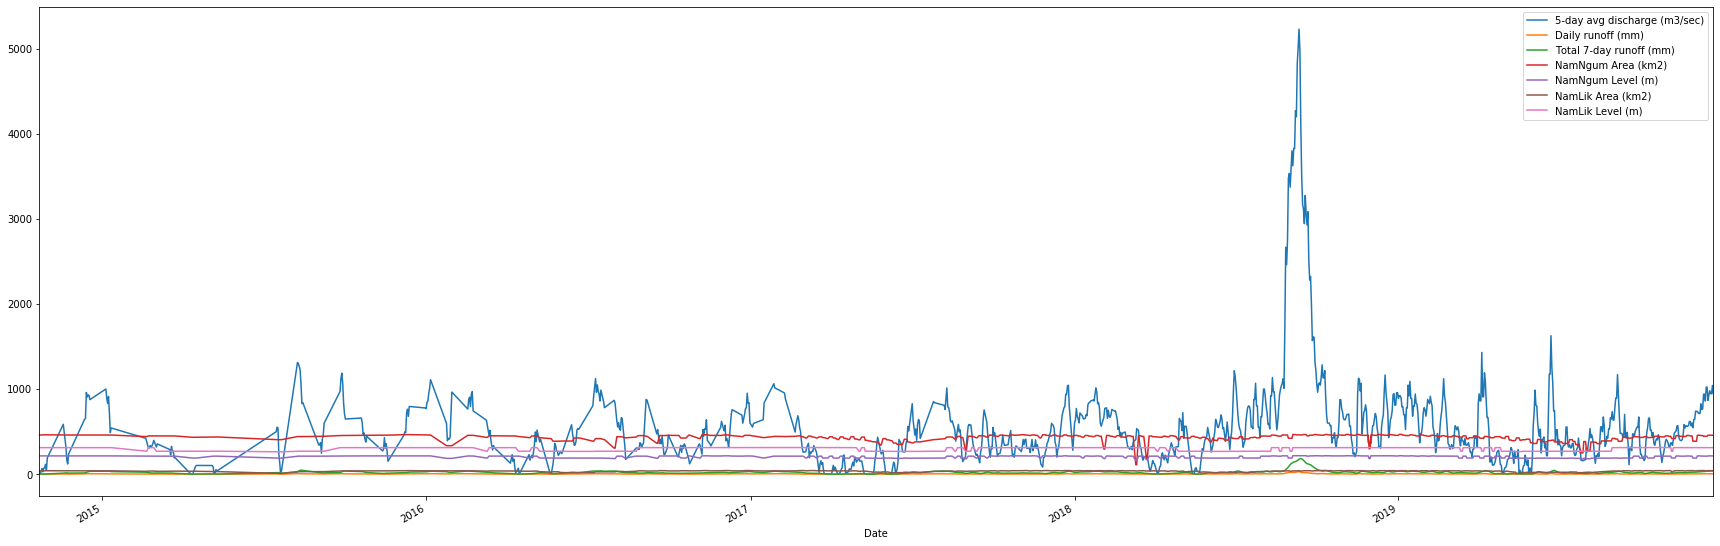

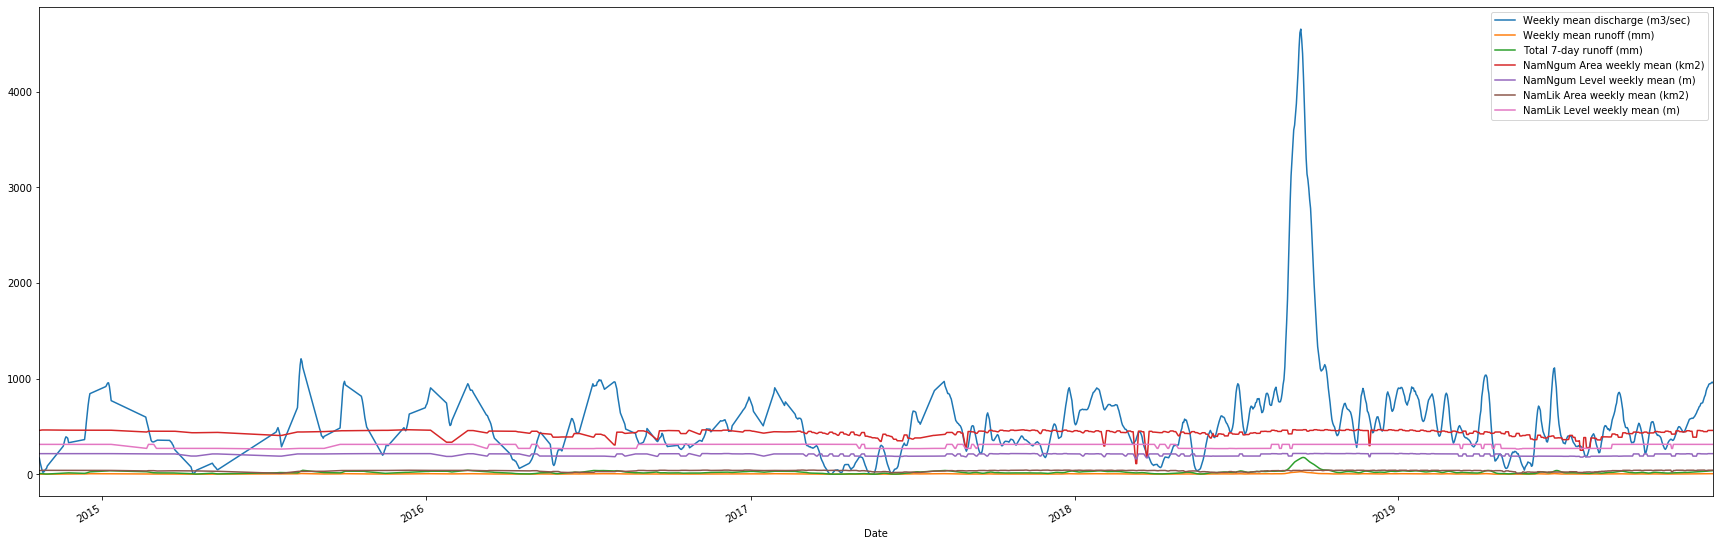

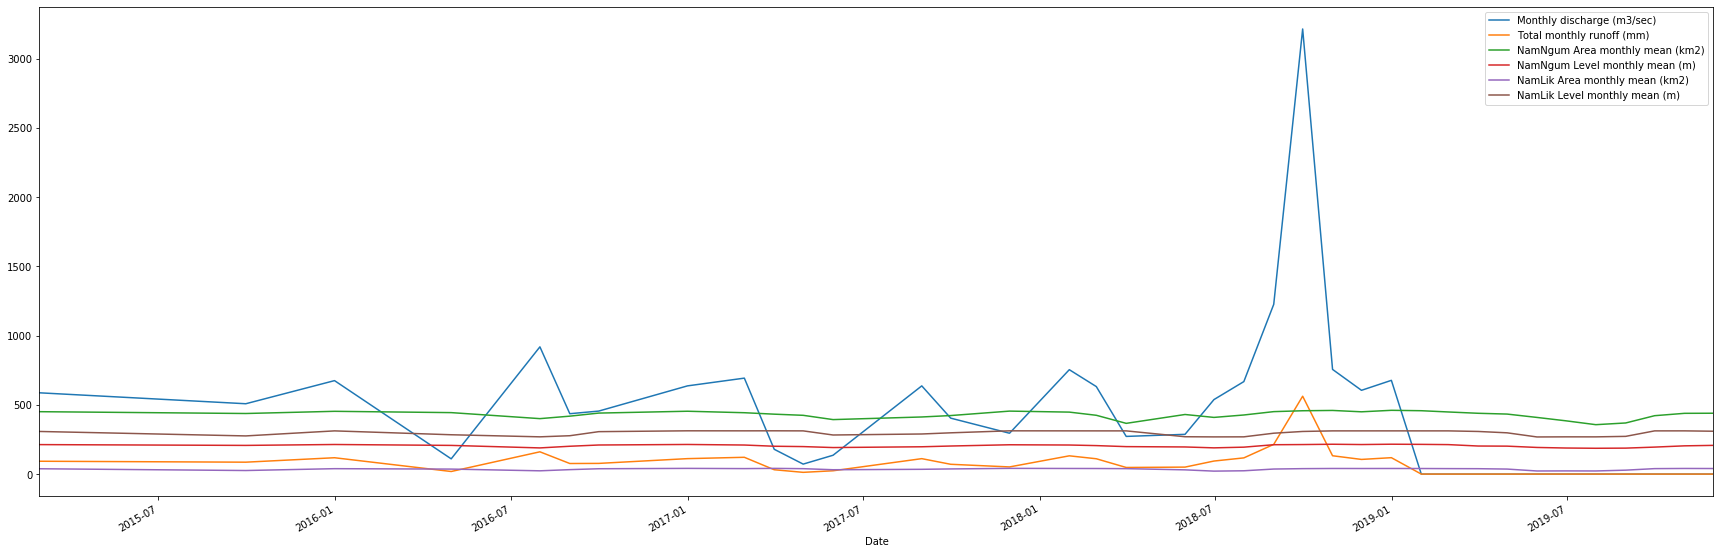

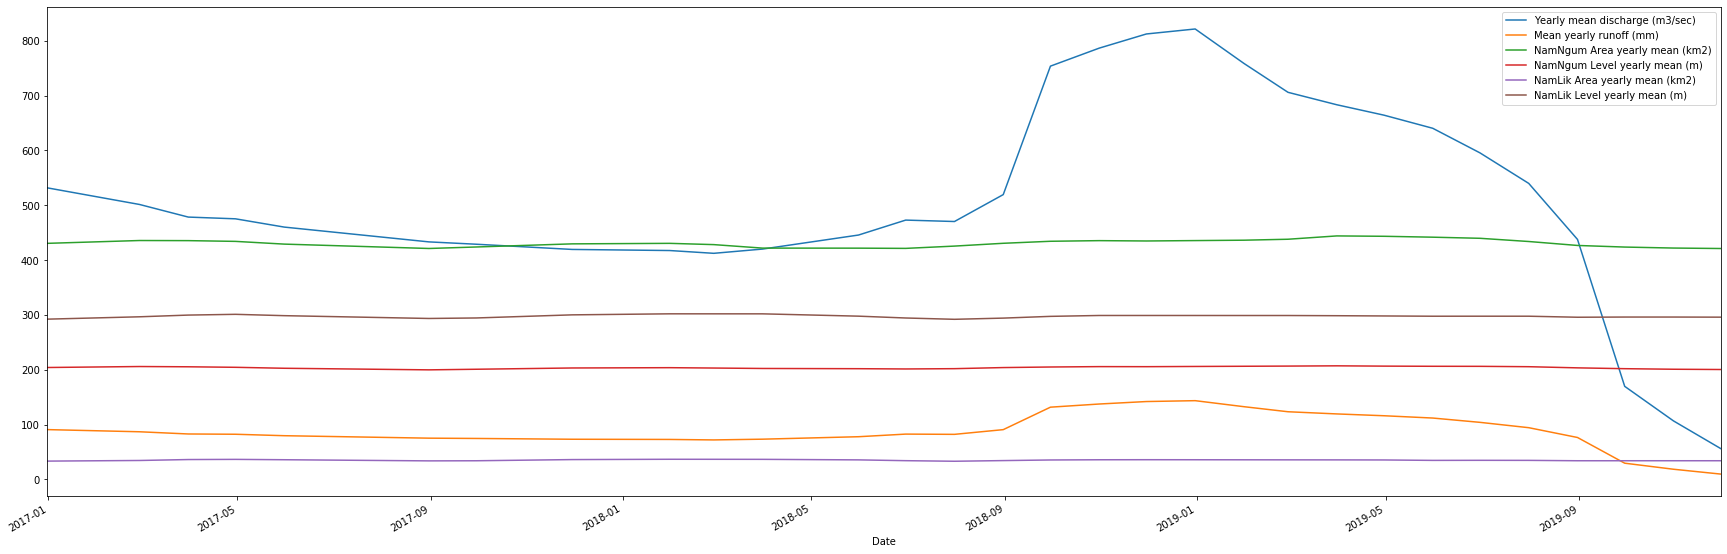

In [91]:
daily_merged.plot(use_index = True, figsize = (30, 10))
weekly_merged.plot(use_index = True, figsize = (30, 10))
monthly_merged.plot(use_index = True, figsize = (30, 10))
yearly_merged.plot(use_index = True, figsize = (30, 10))